# Multi-agent Paperbot
Let's build a simple research assistant for a paper.

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_ollama langchain_experimental

In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("TAVILY_API_KEY")

## Create Tools
**ResearchTeam tools**

In [2]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from langchain.tools.retriever import create_retriever_tool
from langchain_chroma import Chroma
from langchain_ollama.chat_models import ChatOllama
from langchain_ollama import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader

### 논문 삽입 ###
file_path = "./example_data/2408.00714v1.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()



### 대형언어모델, 메모리, 파서 설정 ###
parser = StrOutputParser()
llm = ChatOllama(model="Llama3.2-Korean")
memory = MemorySaver()
embedding = "snowflake-arctic-embed2"


### 리트리버 생성 ###
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OllamaEmbeddings(model=embedding))

retriever = vectorstore.as_retriever()



### 리트리버툴 구축 ###
retriever_tool = create_retriever_tool(
    retriever,
    "paper_retriever",
    "Searches and returns excerpts from the Artificial Intelligence paper.",
)

**Document writing team tools**

This gives the agents access to your file-system

In [30]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\\`\\`\\`python\n{code}\n\\`\\`\\`\nStdout: {result}"

## Helper Utilities
1. Create a worker agent
2. Create a supervisor for the sub-graph

In [5]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, trim_messages


# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: MessagesState) -> MessagesState:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        if response is None:
            next_ = 'FINISH'
        else:
            next_ = response["next"]
        if next_ == "FINISH":
            next_ = END

        return {"next": next_}

    return supervisor_node

## Define Agent Teams 

### Research Team

In [6]:
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent


search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: AgentState) -> AgentState:
    result = search_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="search")
        ]
    }


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: AgentState) -> AgentState:
    result = web_scraper_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="web_scraper")
        ]
    }


retriever_agent = create_react_agent(llm, tools=[retriever_tool], checkpointer=memory)


def retriever_node(state: AgentState) -> AgentState:
    result = retriever_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="retriever")
        ]
    }


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper", "retriever"])

In [7]:
research_builder = StateGraph(MessagesState)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)
research_builder.add_node("retriever", retriever_node)

# Define the control flow
research_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
research_builder.add_edge("search", "supervisor")
research_builder.add_edge("web_scraper", "supervisor")
research_builder.add_edge("retriever", "supervisor")

# Add the edges where routing applies
research_builder.add_conditional_edges("supervisor", lambda state: state["next"])

research_graph = research_builder.compile()

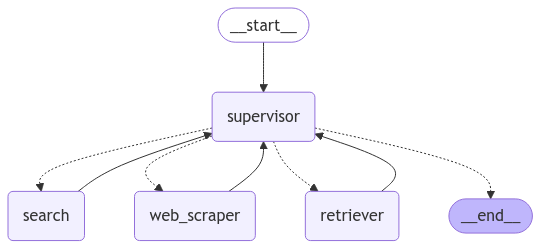

In [16]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [31]:
for s in research_graph.stream(
    {"messages": [("user", "Who introduced the Segment Anyting Model2 in this paper?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': '__end__'}}
---


### Document Writing Team

In [32]:

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: AgentState) -> AgentState:
    result = doc_writer_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="doc_writer")
        ]
    }


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: AgentState) -> AgentState:
    result = note_taking_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="note_taker")
        ]
    }


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: AgentState) -> AgentState:
    result = chart_generating_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="chart_generator")
        ]
    }


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [33]:
# Create the graph here
paper_writing_builder = StateGraph(AgentState)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

# Define the control flow
paper_writing_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
paper_writing_builder.add_edge("doc_writer", "supervisor")
paper_writing_builder.add_edge("note_taker", "supervisor")
paper_writing_builder.add_edge("chart_generator", "supervisor")
# Add the edges where routing applies
paper_writing_builder.add_conditional_edges("supervisor", lambda state: state["next"])

paper_writing_graph = paper_writing_builder.compile()

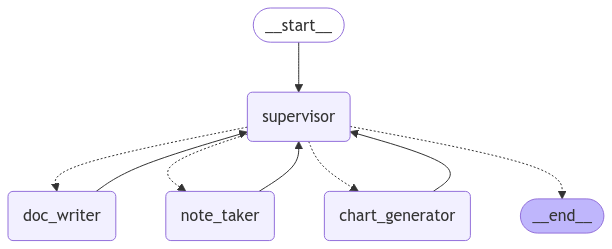

In [34]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [35]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'doc_writer'}}
---


KeyboardInterrupt: 

## Add layers

In [25]:
from langchain_core.messages import BaseMessage


teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [27]:
def call_research_team(state: AgentState) -> AgentState:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="research_team")
        ]
    }


def call_paper_writing_team(state: AgentState) -> AgentState:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="writing_team")
        ]
    }


# Define the graph.
super_builder = StateGraph(AgentState)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

# Define the control flow
super_builder.add_edge(START, "supervisor")
# We want our teams to ALWAYS "report back" to the top-level supervisor when done
super_builder.add_edge("research_team", "supervisor")
super_builder.add_edge("writing_team", "supervisor")
# Add the edges where routing applies
super_builder.add_conditional_edges("supervisor", lambda state: state["next"])
super_graph = super_builder.compile()

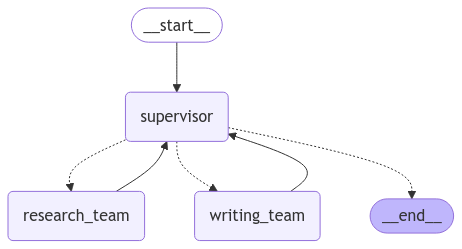

In [28]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [29]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research Segement anything model 2 and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---


KeyboardInterrupt: 